In [6]:
# %config Completer.use_jedi = False

In [262]:
!ls ../labtestonline_datasets/dataset_files

labtest_dataset.csv
labtestsonline_Test.csv
labtestsonline_Test_q_a.csv


list:
- [Preprocess-labtestonline-dataset](#Preprocess-labtestonline-dataset)
- [Plot-question-frequency](#Plot-question-frequency)
- [Questions-process](#Questions-process)
- [Filtered-Back-Translation](Filtered-Back-Translation)
- [Answer-Similarity](#Answer-Similarity)

In [118]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import requests
import json
import ast
import sys
import spacy
import re

### Preprocess labtestonline dataset

In [39]:
df = pd.read_csv('../labtestonline_datasets/dataset_files/labtestsonline_Test.csv')

In [40]:
df.head()

,url,title,also_khown_as,formal_name,last_reviewed,last_modified,body
0,https://labtestsonline.org/tests/serum-free-li...,Serum Free Light Chains,"['Free Light Chains', 'SFLC', 'FLC', 'Kappa an...","['Light Chains, Free', 'Free Kappa/Lambda Ratio']","June 4, 2017.","January 21, 2021.",{'At a Glance': 'At a Glance\nWhy Get Tested?\...
1,https://labtestsonline.org/tests/cyclosporine,Cyclosporine,[],[],"February 14, 2018.","February 20, 2020.",{'At a Glance': 'At a Glance\nWhy Get Tested?\...
2,https://labtestsonline.org/tests/hdl-cholesterol,HDL Cholesterol,"['HDL', 'HDL-C']",['High-density Lipoprotein Cholesterol'],"February 26, 2020.","April 20, 2021.",{'At a Glance': 'At a Glance\nWhy Get Tested?\...
3,https://labtestsonline.org/tests/blood-smear,Blood Smear,"['Peripheral Smear', 'Blood Film', 'Manual Dif...",['Peripheral Blood Smear'],"July 27, 2018.","April 20, 2021.",{'At a Glance': 'At a Glance\nWhy Get Tested?\...
4,https://labtestsonline.org/tests/parvovirus-b19,Parvovirus B19,"['Parvovirus', 'Parvo B19']",[],"July 10, 2017.","September 22, 2020.",{'At a Glance': 'At a Glance\nWhy Get Tested?\...


In [85]:
data = []
for row in df.iterrows():
    new_row = list(row[1])[:-1]
    body = ast.literal_eval(list(row[1])[-1].replace('See More\\nSee Less','').replace('See More Common Questions\\nSee Less Common Questions',''))  
    q_a = dict()
    for key in body.keys():
        value = body.get(key)
        if key != 'View Sources' and value.find('?')>0:
#             value.replace('')
            lines = value.split('\n')
            ans = ''
            qus = ''
            find_q = False
            for line in lines:
#                 print(line)
#                 input()
                if line.find('?')>0:
                    if find_q:
                        if len(qus)<150:
                            if qus.strip().find('    ')>0:
                                qus = re.sub('.*\s\s\s\s','',qus)
#                                 print(qus.strip(), '|||', ans, end='\n\n')
                            q_a[qus] = ans.strip()
                        ans = ''
                        find_q = False
                    tmp = line.split('?')
                    if len(tmp[1])>2:
                        q = tmp[0].strip()+'?'
                        a = tmp[1].strip()
                        if len(q)<150:
                            if q.strip().find('    ')>0:
                                q = re.sub('.*\s\s\s\s','',q)
#                                 print(q.strip(), '|||', a, end='\n\n')
                            q_a[q] = a
                    else:
                        find_q = True
                        qus = line.strip()
                elif find_q:
                    ans = ans + line+'\n'
            if qus != '' and len(qus)>3 and len(qus)<150:
                if qus.find('   ')>0:
                    qus = re.sub('.*\s\s\s\s','',qus)
#                     print(qus, '|||', ans, end='\n\n')
                q_a[qus] = ans.strip()
    
    for qus,ans in q_a.items():
        tmp = new_row.copy()
        tmp.append(qus)
        tmp.append(ans)
        data.append(tmp)
#     break

In [88]:
new_df = pd.DataFrame(data,columns=['url','title','also_khown_as','formal_name','last_reviewed','last_modified','question','answer'])
new_df.describe()

,url,title,also_khown_as,formal_name,last_reviewed,last_modified,question,answer
count,4521,4521,4521,4521,4521,4521,4521,4521
unique,364,364,322,165,287,88,1445,4036
top,https://labtestsonline.org/tests/kidney-stone-...,Celiac Disease Antibody Tests,[],[],"September 19, 2018.","March 25, 2021.",What is being tested?,None
freq,19,19,353,2355,53,724,326,184


In [227]:
new_df.head()

,url,title,also_khown_as,formal_name,last_reviewed,last_modified,question,answer
0,https://labtestsonline.org/tests/serum-free-li...,Serum Free Light Chains,"['Free Light Chains', 'SFLC', 'FLC', 'Kappa an...","['Light Chains, Free', 'Free Kappa/Lambda Ratio']","June 4, 2017.","January 21, 2021.",Why Get Tested?,"To help detect, diagnose, and monitor plasma c..."
1,https://labtestsonline.org/tests/serum-free-li...,Serum Free Light Chains,"['Free Light Chains', 'SFLC', 'FLC', 'Kappa an...","['Light Chains, Free', 'Free Kappa/Lambda Ratio']","June 4, 2017.","January 21, 2021.",When To Get Tested?,"When you have bone pain, fractures, anemia (wi..."
2,https://labtestsonline.org/tests/serum-free-li...,Serum Free Light Chains,"['Free Light Chains', 'SFLC', 'FLC', 'Kappa an...","['Light Chains, Free', 'Free Kappa/Lambda Ratio']","June 4, 2017.","January 21, 2021.",Sample Required?,A blood sample drawn from a vein in your arm
3,https://labtestsonline.org/tests/serum-free-li...,Serum Free Light Chains,"['Free Light Chains', 'SFLC', 'FLC', 'Kappa an...","['Light Chains, Free', 'Free Kappa/Lambda Ratio']","June 4, 2017.","January 21, 2021.",Test Preparation Needed?,None
4,https://labtestsonline.org/tests/serum-free-li...,Serum Free Light Chains,"['Free Light Chains', 'SFLC', 'FLC', 'Kappa an...","['Light Chains, Free', 'Free Kappa/Lambda Ratio']","June 4, 2017.","January 21, 2021.",What is being tested?,Light chains are proteins produced by immune c...


In [89]:
new_df.to_csv('../labtestonline_datasets/dataset_files/labtestsonline_Test_q_a.csv', index=False)

### Plot question frequency

<AxesSubplot:title={'center':'Count of question'}, xlabel='Questions', ylabel='Counts'>

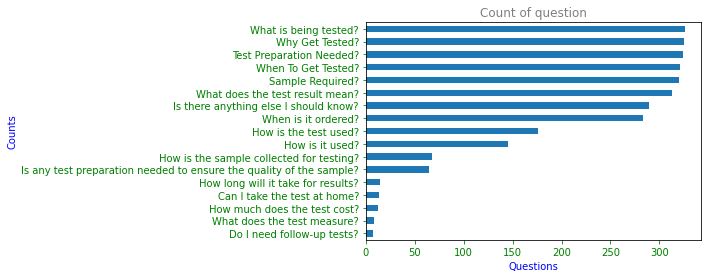

In [60]:
df_labtestonline = pd.read_csv('../labtestonline_datasets/dataset_files/labtestsonline_Test_q_a.csv')
fig, ax = plt.subplots()
ax.set_title('Count of question')
ax.title.set_color('gray')
ax.set_xlabel('Questions')
ax.set_ylabel('Counts')
ax.xaxis.label.set_color('blue')
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='x', colors='green')
ax.tick_params(axis='y', colors='green')
df_labtestonline.question.value_counts().sort_values()[-17:].plot(ax=ax, kind='barh')
# plt.savefig('question frequency-LabtestOnline.png',bbox_inches='tight', dpi=150)

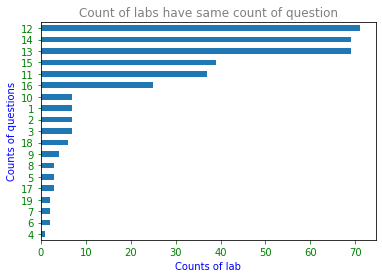

In [92]:
fig, ax = plt.subplots()
ax.set_title('Count of labs have same count of question')
ax.title.set_color('gray')
ax.set_xlabel('Counts of lab')
ax.set_ylabel('Counts of questions')
ax.xaxis.label.set_color('blue')
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='x', colors='green')
ax.tick_params(axis='y', colors='green')
df_labtestonline.title.value_counts().sort_values().value_counts().sort_values().plot(ax=ax, kind='barh')
# plt.savefig('question count frequency-LabtestOnline.png',bbox_inches='tight', dpi=150)

(array([2309.,  898.,  454.,  319.,  302.,  115.,   68.,   32.,   11.,
          13.]),
 array([ 12. ,  25.4,  38.8,  52.2,  65.6,  79. ,  92.4, 105.8, 119.2,
        132.6, 146. ]),
 <BarContainer object of 10 artists>)

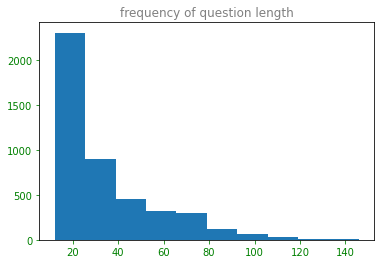

In [93]:
fig, ax = plt.subplots()
ax.set_title('frequency of question length')
ax.title.set_color('gray')
# ax.set_xlabel('Counts of lab')
# ax.set_ylabel('Counts of questions')
ax.xaxis.label.set_color('blue')
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='x', colors='green')
ax.tick_params(axis='y', colors='green')
# df_labtestonline.title.value_counts().sort_values().value_counts().sort_values().plot(ax=ax, kind='bar')
questions_len = [len(i) for i in df_labtestonline.question.values]
plt.hist(questions_len)

In [94]:
max(questions_len)

146

## Questions process

In [62]:
# from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\98938\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\98938\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\98938\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
white_list = ['why','what','while','during','against','after','below','up','down','under','over','once',
             'when','where','how','all','most','such','same','can','will','should','who','whom','which',
             'are','do','does','did','until','my','there','needed','have','has','had','any','need']
stop = [word for word in stop if word not in white_list]
black_list = ['test']
stop = [word for word in stop if word in black_list or stop]
# stop

#### question preprocess

In [180]:
"""question preprocess"""
df_labtestonline = pd.read_csv('../labtestonline_datasets/dataset_files/labtestsonline_Test_q_a.csv')
df_labtestonline = df_labtestonline[df_labtestonline.question != 'You may be instructed to avoid certain foods and medications prior to this test. (For more details, see the "What is being tested?'] 
df_labtestonline = df_labtestonline[df_labtestonline.question != 'Did You Know?']
df_labtestonline = df_labtestonline[df_labtestonline.question != 'Have Diabetes?']
df_labtestonline = df_labtestonline[df_labtestonline.question != 'Genetics Home Reference: What is pharmacogenomics?']
df_labtestonline = df_labtestonline[df_labtestonline.question != 'Mayo Clinic: Alzheimer genes: Are you at risk?']
df_labtestonline = df_labtestonline[df_labtestonline.question != 'Lupus Foundation of America: What are antiphospholipid antibodies?']
df_labtestonline = df_labtestonline[df_labtestonline.question != 'Myasthenia Gravis Foundation of America: What is MG?']
df_labtestonline = df_labtestonline[df_labtestonline.question != 'National Kidney Foundation: What are immunosuppressants?']
df_labtestonline = df_labtestonline[df_labtestonline.question != 'Centers for Disease Control and Prevention. Which STD tests should I get?']
df_labtestonline = df_labtestonline[df_labtestonline.answer != 'What are the symptoms?']


# questions = df_labtestonline.question 
len(df_labtestonline)
# questions
# questions = df_labtestonline.question.str.lower()
# questions = questions.str.replace('[^\w\s]',' ')

4502

In [144]:
df_labtestonline[df_labtestonline.question == 'Myasthenia Gravis Foundation of America: What is MG?']

,url,title,also_khown_as,formal_name,last_reviewed,last_modified,question,answer
2138,https://labtestsonline.org/tests/anti-musk-mus...,Anti-MuSK (muscle-specific kinase) Antibodies,"['MuSK Autoantibody', 'MuSK Antibody, IgG']","['Muscle-Specific Kinase (MuSK) Autoantibody, ...","July 22, 2020.","October 5, 2020.",Myasthenia Gravis Foundation of America: What ...,Muscular Dystrophy Association: Myasthenia Gra...
3996,https://labtestsonline.org/tests/acetylcholine...,Acetylcholine Receptor (AChR) Antibody,"['AChR Antibody', 'Muscle nicotinic Acetylchol...","['Myasthenia Gravis (MG) Evaluation, serum']","May 4, 2020.","July 22, 2020.",Myasthenia Gravis Foundation of America: What ...,Muscular Dystrophy Association: Myasthenia Gra...


In [6]:
# Cleaning
import unicodedata
import string
def cleanQuestions(questions):
    def remove_accented_chars(text):
        new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return new_text
    def remove_punctuation(text):
        text = re.sub('['+string.punctuation+'+]',' ',text)
        text = re.sub('[\s+]',' ',text)
        return text
    questions = questions.apply(lambda x: str(x).lower())
    questions = questions.apply(remove_accented_chars)
    questions = questions.apply(remove_punctuation) 
    questions = questions.apply(lambda s: re.sub(" \d+", " ", s))
    questions = questions.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop)) # remove stop words 
    return questions
questions_clean = cleanQuestions(questions)
words = ' '.join(questions_clean.values).split(' ')

In [8]:
from collections import Counter
counts = Counter(words)
counts.most_common(10)

[('test', 1194),
 ('what', 1098),
 ('tested', 1043),
 ('get', 729),
 ('when', 643),
 ('how', 633),
 ('sample', 484),
 ('why', 450),
 ('does', 434),
 ('should', 420)]

In [9]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
df_labtestonline['questions_tokens'] = questions_clean.apply(lambda x: [item for item in w_tokenizer.tokenize(x)])
# df_labtestonline.head(5)

In [10]:
questions_clean_uniq = questions_clean.unique()

In [120]:
"""Questions similarity"""
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [71]:

# questions = [str(q) for q in df_labtestonline.question.values]
# questions = questions_tokens.copy()
questions = questions[:100]

In [72]:
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(questions_clean_uniq)

In [73]:
doc_term_matrix = sparse_matrix.todense()
df_vec = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=questions_clean_uniq)
df_vec.head()

,a1c,aat,abl1,abnormal,abnormalities,abnormally,abo,absorb,abuse,accurate,...,year,years,yet,yogurt,young,zika,zinc,znt8a,zollinger,zpp
why get tested,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
when get tested,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sample required,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
test preparation needed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
what tested,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
df_vec.loc[['test preparation needed']]

,a1c,aat,abl1,abnormal,abnormalities,abnormally,abo,absorb,abuse,accurate,...,year,years,yet,yogurt,young,zika,zinc,znt8a,zollinger,zpp
test preparation needed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
# Compute Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
# frequentCols = df_labtestonline.question.values[:10]
frequentCols = questions_clean.values[:100]
similarity = cosine_similarity(df_vec.loc[frequentCols.tolist()], df_vec)

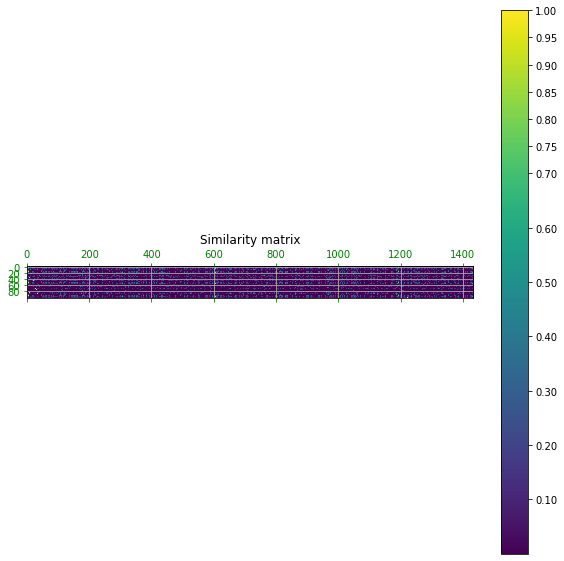

In [76]:
import matplotlib.pyplot as plt
 
# labels = []
# for hood in hood_menu_data:
#     labels.append(hood["properties"]['NAME'])

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(similarity, interpolation='nearest')
ax.grid(True)
ax.tick_params(axis='x', colors='green')
ax.tick_params(axis='y', colors='green')
plt.title('Similarity matrix')
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()


In [64]:
"""Question Clustering"""
# KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans

In [78]:
tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df=0.7)
tfidf = tfidf_vectorizer.fit_transform(questions_clean_uniq)
terms = tfidf_vectorizer.get_feature_names()
print(tfidf_vectorizer.get_feature_names()[:20])
print(len(tfidf_vectorizer.get_feature_names()))
print(tfidf.shape)

['a1c', 'abnormal', 'abo', 'acetaminophen', 'acid', 'ada', 'addition', 'additional', 'adrenal', 'adults', 'affect', 'after', 'against', 'albumin', 'alk', 'all', 'allergies', 'allergy', 'also', 'always']
645
(1434, 645)


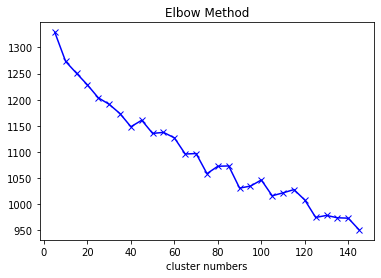

In [79]:
# Using elbow method to determine number of cluster

K = range(5,150,5)
SSE = []
for k in K:
    kmeans = MiniBatchKMeans(n_clusters = k, batch_size = 50)
    kmeans.fit(tfidf)
    SSE.append(kmeans.inertia_)
    
plt.plot(K,SSE,'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [80]:
# Function to quickly evaluate clustering solutions
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from time import time
def evaluate(clust, X):
    sil = silhouette_score(X, clust.labels_, metric='euclidean')
    # performance.loc[i,'Silhouette'] = sil
    print("Silhouette Score: %.3f" % sil)

    cahr = calinski_harabasz_score(X.toarray(), clust.labels_)
    # performance.loc[i,'Calinski'] = cahr 
    print("Calinski-Harabasz Index: %.3f" % cahr)

    dbs = davies_bouldin_score(X.toarray(), clust.labels_)
    # performance.loc[i,'daviesB'] = dbs
    print("Davies Bouldin Score: %.3f" % dbs)

In [81]:
# Using KMeans to clustering
n_clusters = 10

# for nc in n_clusters:
clust = KMeans(n_clusters=n_clusters)
clust.fit(tfidf)
centers = clust.cluster_centers_.argsort()[:,::-1]
# print("Len of Labels: ",len(set(clust.labels_)), " Params: ", clust.get_params())
for i in range(0,n_clusters):
    word_list=[]
    print("cluster%d:"% i)
    for j in centers[i,:10]:
        word_list.append(terms[j])
    print(word_list) 

cluster0:
['long', 'take', 'how', 'will', 'results', 'need', 'does', 'get', 'test', 'my']
cluster1:
['how', 'are', 'there', 'test', 'used', 'do', 'treated', 'will', 'my', 'testing']
cluster2:
['office', 'my', 'can', 'healthcare', 'performed', 'doctor', 'done', 'practitioner', 'test', 'testing']
cluster3:
['what', 'tests', 'might', 'done', 'may', 'my', 'mean', 'result', 'addition', 'does']
cluster4:
['why', 'my', 'healthcare', 'would', 'practitioner', 'test', 'important', 'sample', 'had', 'providers']
cluster5:
['national', 'institute', 'library', 'medlineplus', 'medicine', 'what', 'heart', 'lung', 'blood', 'consumer']
cluster6:
['have', 'should', 'everyone', 'test', 'tested', 'done', 'will', 'my', 'does', 'all']
cluster7:
['get', 'infection', 'can', 'should', 'when', 'once', 'had', 'treated', 'have', 'prevent']
cluster8:
['what', 'are', 'treatment', 'disease', 'syndrome', 'tests', 'american', 'difference', 'test', 'cancer']
cluster9:
['can', 'my', 'test', 'do', 'home', 'level', 'blood'

In [82]:
evaluate(clust,tfidf)

Silhouette Score: 0.028
Calinski-Harabasz Index: 16.470
Davies Bouldin Score: 4.836


In [253]:
# clust=KMeans()
# params={
#     'n_clusters': np.arange(10,20,5),
#     'init': ['k-means++','random'],
# #     'n_init':[10,20],
#     'precompute_distances':[True,False,"auto"]
# }
# evaluate_clust(clust,params,features='tfidf',i=0)

In [189]:
# Nearest question to each question
questions_unique = list(set(df_labtestonline.question.str.lower()))
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=1.0)
tfidf = tfidf_vectorizer.fit_transform(questions_unique)
terms = tfidf_vectorizer.get_feature_names()
print(tfidf_vectorizer.get_feature_names()[:20])
print(len(tfidf_vectorizer.get_feature_names()))
print(tfidf.shape)

similarity_matrix = cosine_similarity(tfidf,tfidf)

['125', '15', '17', '19', '20210', '24', 'a1c', 'abl1', 'abnormal', 'about', 'absorption', 'abuse', 'accurate', 'acetaminophen', 'acetylcholine', 'achr', 'acid', 'act', 'acth', 'actin']
826
(4467, 826)


In [190]:
len(questions_unique)

4467

In [188]:
similarity_matrix = cosine_similarity(tfidf,tfidf)
for n in range(50):
    similarity_matrix[n,similarity_matrix[n].argmax()] = 0
    a = similarity_matrix[n].argmax()
#     print(a, similarity_matrix[n][a-2:a+2])
#     break
    if similarity_matrix[n,a]>0.0:
        print(a, similarity_matrix[n,a])
        print(questions_unique[n],'\n'+questions_unique[a], end='\n\n')

1497 0.7967917294955567
when is the ck-mb test ordered? 
when to get ck-mb tested?

219 0.6834123021697184
is test preparation needed for sirolimus test? 
sample required for sirolimus test?

4317 0.8407536439691573
when to get lactose tolerance tests tested? 
why get lactose tolerance tests test?

3074 0.8947386159532095
what does the factor v leiden mutation and pt 20210 mutation result mean? 
how is the factor v leiden mutation and pt 20210 mutation used?

1605 0.874886395452356
is test preparation needed for activated clotting time (act) test? 
sample required for activated clotting time (act) test?

347 0.8351687972031027
how is the sample collected for emergency and overdose drug testing testing? 
how is emergency and overdose drug testing used?

2310 0.7435712231893922
why get lipase test? 
when to get lipase tested?

2793 0.8098523983909296
can vitamin a testing be done in my healthcare practitioner's office? 
can histamine testing be done in my healthcare practitioner's office

In [128]:
similarity_matrix = cosine_similarity(tfidf,tfidf)
n = 5
similarity_matrix[n,similarity_matrix[n].argmax()] = 0
a = similarity_matrix[n].argmax()
print(a, similarity_matrix[n][a-2:a+2])
# break
if similarity_matrix[n,a]>0.0:
    print(a, similarity_matrix[n,a])
    print(questions_unique[n],'\n'+questions_unique[a], end='\n\n')

456 [0.06871128 0.         0.97514899 0.10488654]
456 0.9751489948861484
how long will it take to get my results? 
how long will it take to get results?



In [129]:
df_labtestonline[df_labtestonline['question']=='See "How is it used?'].answer.values

array(['" under Common Questions below for details on AFB tests.'],
      dtype=object)

In [192]:
# Question clustring with SentenceTransformer
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import random

In [193]:
df_labtestonline = pd.read_csv('../labtestonline_datasets/dataset_files/labtestsonline_Test_q_a.csv')
questions = df_labtestonline.question.unique().tolist()

In [194]:
test_cases = random.sample(range(0, len(questions_clean_uniq) - 1), 60)
model = SentenceTransformer('paraphrase-mpnet-base-v2')
sentence_embeddings = model.encode(questions_clean_uniq)
sentence_embeddings.shape

(1434, 768)

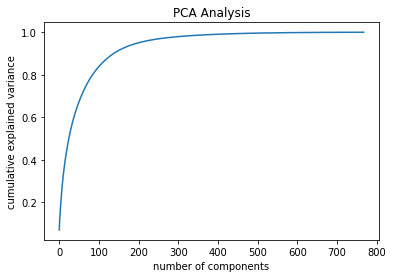

In [195]:
pca = PCA().fit(sentence_embeddings)

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA Analysis')
# plt.ylim(0,100.5)
# plt.figure(figsize=(12,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [109]:
n_dimention = 100
pca = PCA(n_components=n_dimention)
reduced_data = pca.fit_transform(sentence_embeddings)
reduced_data.shape

(1434, 100)

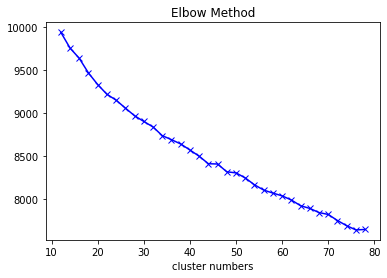

In [200]:
SSE = []

for k in range(12, 80, 2):
    kmeans = KMeans (n_clusters = k)
    kmeans.fit (sentence_embeddings)
    SSE.append (kmeans.inertia_)
    
plt.plot(range(12, 80, 2), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [201]:
n_clusters = 8

km = KMeans(n_clusters=n_clusters)

km.fit(sentence_embeddings)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  70  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 70, 'n_init': 10, 'n_jobs': 'deprecated', 'precompute_distances': 'deprecated', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [202]:
predicts = {}
for i in range(n_clusters):
    predicts[i] = []
for i in test_cases:
    predicts[km.predict(sentence_embeddings[i].reshape(-1, 1).T)[0]].append(questions_clean_uniq[i])
for i in range(n_clusters):
    print('questions for cluster:', i)
    [print(j) for j in predicts[i]]
    print()

questions for cluster: 0

questions for cluster: 1

questions for cluster: 2

questions for cluster: 3
can vitamin testing done my healthcare practitioner office
can molecular testing performed my healthcare provider office my local hospital laboratory
can anti dsdna test performed my healthcare practitioner office
can total ige test performed my doctors office
can ena panel performed my healthcare practitioner office

questions for cluster: 4
what lab tests may performed
details various tests see table under common questions how used
what does test measure
would testing also performed man

questions for cluster: 5
how are shiga toxin producing e coli infections digestive tract treated

questions for cluster: 6

questions for cluster: 7

questions for cluster: 8

questions for cluster: 9
what ldl particle testing

questions for cluster: 10

questions for cluster: 11
should everyone tested ccp antibody
who orders sirolimus tests

questions for cluster: 12

questions for cluster: 13

que

(array([193.,   0., 262.,   0., 168.,   0., 216.,   0., 204.,   0., 255.,
          0.,  69.,   0.,  67.]),
 array([0.        , 0.46666667, 0.93333333, 1.4       , 1.86666667,
        2.33333333, 2.8       , 3.26666667, 3.73333333, 4.2       ,
        4.66666667, 5.13333333, 5.6       , 6.06666667, 6.53333333,
        7.        ]),
 <BarContainer object of 15 artists>)

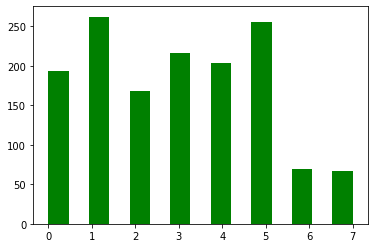

In [116]:
plt.hist(km.labels_, bins=15, color='green')

### Filtered Back Translation

In [168]:
!pip install -q mtranslate
!pip install -q transformers

In [169]:
import torch
from mtranslate import translate
from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import tqdm

In [170]:
class GoogleBackTranslator():
    def __init__(self, n_diff:int=1):
        # minimum number of differences
        self.n_diff = n_diff

    def __call__(self, sentence:str, languages:list):
        # any languages from fa .... 
        for i, lang in enumerate(languages[:-1]):
            sentence = translate(sentence, from_language=lang, to_language=languages[i+1])
        # the last back to the first element of the languages list
        back_translated = translate(sentence, from_language=languages[i+1], to_language=languages[0])
        tokens = set(back_translated.split(' '))
        if len(tokens.intersection(sentence.split(' '))) >= len(tokens)-self.n_diff:
            return ''
        return back_translated

In [178]:
bk = GoogleBackTranslator(n_diff=2)
bk("what's up buddy?", ['en', 'ru'])

''

In [191]:
class SentenceSimilarity():
    def __init__(self, max_len=16, model_name='m3hrdadfi/bert-fa-base-uncased-wikitriplet-mean-tokens'):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).eval()
        self.max_len = max_len

    def __call__(self, text:list):
        # tokenization step
        tokens = self.tokenizer(text, truncation=True, padding='max_length', 
                                max_length=self.max_len, return_tensors='pt')

        # model.forward step
        with torch.no_grad():
            embeddings = self.model(**tokens).last_hidden_state
        # Create masked embeddings (just expend size)
        mask = tokens['attention_mask'].unsqueeze(-1).expand(embeddings.shape).float()
        # create sentence embedding (sum embs / sum mask)
        sentence_embeddings = torch.sum(embeddings * mask, dim=1) / torch.clamp(mask.sum(1), min=1e-9) 
        # expand dim for each embedding (helpful for cosine similarity)
        return sentence_embeddings.unsqueeze(1)

    def cosine_similarity(self, a:str, b:str):
        a, b = self([a, b])
        return torch.cosine_similarity(a, b).item()

In [192]:
ss = SentenceSimilarity(max_len=32)

404 Client Error: Not Found for url: https://huggingface.co/m3hrdadfi/bert-en-base-uncased-wikitriplet-mean-tokens/resolve/main/config.json


OSError: Can't load config for 'm3hrdadfi/bert-en-base-uncased-wikitriplet-mean-tokens'. Make sure that:

- 'm3hrdadfi/bert-en-base-uncased-wikitriplet-mean-tokens' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'm3hrdadfi/bert-en-base-uncased-wikitriplet-mean-tokens' is the correct path to a directory containing a config.json file



In [184]:
 ss.cosine_similarity(a="what causes pancreatic insufficiency?", b='what causes male infertility?')

0.8863288164138794

In [187]:
class FilteredBackTranslation():
      # TODO: Parrallel BackTranslator
    def __init__(self, min_score:float=.8, n_diff:int=1, similar_model_name:str='m3hrdadfi/bert-fa-base-uncased-wikitriplet-mean-tokens'):
        self.min_score = min_score
        self.back_translator = GoogleBackTranslator(n_diff=n_diff)
        self.sentence_similar = SentenceSimilarity(model_name=similar_model_name)
        # I found that the following languages work well for Persian back translation
        self.languages = [['en', 'fa'], ['en', 'ru'], ['en', 'ar'], ['en', 'fr']]

    def __call__(self, sentences:list, top_chain:int=2):
        # top chain: use all those 4 languages for creating backtranslation
        augmented = []
        for i, s in tqdm(enumerate(sentences), total=len(sentences)):
            paraphrazes = []
            scores = []
            for langs in self.languages[:top_chain]:
                aug = self.back_translator(s, languages=langs) 
                if aug not in paraphrazes:
                    score = self.sentence_similar.cosine_similarity(s, aug)
                    if score >= self.min_score:
                        scores.append(score)
                        paraphrazes.append(aug)

        if len(scores)>0:
            augmented.append({'id': i, 'org': s, 'aug': paraphrazes, 'score': scores})

        return augmented

In [188]:
augmenter = FilteredBackTranslation(min_score=.9)

In [190]:
sentences = ['Are there other genetic changes that my healthcare practitioner may test for with leukemia?']
augmenter(sentences, top_chain=4) 

  0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 0,
  'org': 'Are there other genetic changes that my healthcare practitioner may test for with leukemia?',
  'aug': ['Are there other genetic changes that my healthcare provider might test for leukemia?',
   'Are there other genetic changes my doctor can test for leukemia?',
   'Are there other genetic changes my healthcare practitioner might experience with leukemia?',
   'Are there other genetic changes my healthcare professional can look for with leukemia?'],
  'score': [0.9713664054870605,
   0.9194540977478027,
   0.9506654739379883,
   0.9540624618530273]}]

### Answer Similarity

In [12]:
df_labtestonline = pd.read_csv('../labtestonline_datasets/dataset_files/labtestsonline_Test_q_a.csv')
qa = {}
for key, val in zip(cleanQuestions(df_labtestonline.question).values, cleanQuestions(df_labtestonline.answer).values):
    qa[key] = val

In [13]:
list(qa.keys())[:2], list(qa.values())[:2]

(['why get tested', 'when get tested'],
 ['detect high levels lactate blood which may indication lack oxygen hypoxia presence conditions cause excess production insufficient clearing lactate blood test meant used screening health status',
  'when have symptoms such rapid breathing nausea sweating suggest lack oxygen abnormal blood ph acid base imbalance when healthcare practitioner suspects may experiencing sepsis shock heart attack severe congestive heart failure kidney failure inadequately treated uncontrolled diabetes when healthcare practitioner suspects have inherited rare metabolic mitochondrial disorder when have symptoms lactic acidosis such sweet smelling breath belly pain confusion cool clammy skin'])

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

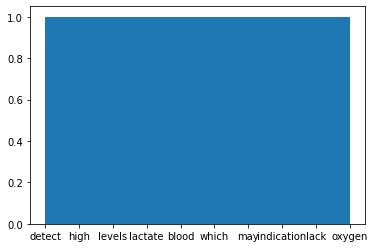

In [56]:
counts = Counter(' '.join(list(qa.values())).split(' '))
plt.hist(' '.join(list(qa.values())).split(' ')[:10],)

### Q&A with Bert
- on google colab

### Reshape question with lab name

In [123]:
df_labtestonline.question.value_counts().sort_values()[:-79]

How long will it take for androstenedione test results?                         1
What is the difference between osmolality and osmolarity?                       1
Do my family members also need to be tested?                                    1
Who performs a kidney stone analysis?                                           1
How long will it take for my ESR result?                                        1
                                                                               ..
Is there any benefit to repeating the test?                                     1
What should I do if I forget to save one urine sample during the collection?    1
Can glucose testing be done when I have not fasted?                             1
How is transferrin saturation calculated?                                       1
Is there anything I can do to lower my CK level?                                1
Name: question, Length: 1364, dtype: int64

In [135]:
df_tmp = pd.DataFrame(columns=['oldquestion', 'questionttemplate'])
for key, value in df_labtestonline.question.value_counts().sort_values()[-79:].iteritems():
    name = df_labtestonline[df_labtestonline['question']==key].title.values[0]   
    print('Test name: ', df_labtestonline[df_labtestonline['question']==key].values)
    qt = input(key)
    if qt!='':
        df_tmp = df_tmp.append({'oldquestion': key, 'questionttemplate': qt}, ignore_index=True)
    else:
        df_tmp = df_tmp.append({'oldquestion': key, 'questionttemplate': key}, ignore_index=True)
    print()
#     break
df_tmp

Test name:  [['https://labtestsonline.org/tests/valproic-acid' 'Valproic Acid'
  "['Valproate', 'Free Valproic Acid']" '[]' 'October 1, 2018.'
  'March 25, 2021.'
  "Can I test my valproic acid level at my doctor's office?"
  'No, it requires specialized equipment. Blood samples are collected from a vein in the arm and tested in the laboratory.']]
Can I test my valproic acid level at my doctor's office?

Test name:  [['https://labtestsonline.org/tests/myoglobin' 'Myoglobin'
  "['Urine Myoglobin', 'Serum Myoglobin']" '[]' 'December 6, 2019.'
  'December 6, 2019.' 'What is rhabdomyolysis?'
  'Rhabdomyolysis is the rapid breakdown of muscle tissue. This condition can be caused by serious injury to muscles from a number of different sources. Examples include: Trauma, crushing injuries such as car accidents']
 ['https://labtestsonline.org/tests/creatine-kinase-ck'
  'Creatine Kinase (CK)'
  "['CK', 'Total CK', 'Creatine Phosphokinase', 'CPK']" '[]'
  'July 24, 2016.' 'June 18, 2021.' 'What 

Is it really necessary to collect urine for 24 hours?Is it really necessary to collect urine for 24 hours in <test>?

Test name:  [['https://labtestsonline.org/tests/glucose-tests' 'Glucose Tests'
  "['Fasting Blood Glucose (FBG)', 'Blood Sugar', 'Fasting Blood Sugar (FBS)', 'Fasting Plasma Glucose (FPG)']"
  "['Blood Glucose (Fasting)', 'Blood Glucose (Random)']"
  'August 18, 2020.' 'April 20, 2021.' 'Have Diabetes?'
  'Take Care When Preparing for Lab Tests   (January 10, 2019.']
 ['https://labtestsonline.org/tests/continuous-glucose-monitoring'
  'Continuous Glucose Monitoring'
  "['CGM', 'Interstitial Glucose Monitoring', 'Real-time CGM', 'Intermittently Scanning CGM ']"
  '[]' 'May 3, 2019.' 'January 27, 2021.' 'Have Diabetes?'
  'Take Care When Preparing for Lab Tests   (January 10, 2019.']]
Have Diabetes?

Test name:  [['https://labtestsonline.org/tests/inhibin-b-infertility'
  'Inhibin B in Infertility' '[]' "['Inhibin B Infertility, Serum']"
  'December 4, 2020.' 'January 21,

How can my actual GFR be determined?

Test name:  [['https://labtestsonline.org/tests/anti-lkm-1' 'Anti-LKM-1'
  "['Liver Kidney Microsomal Type 1 Antibodies', 'LKM1 Antibodies', 'Anti-Liver/Kidney Microsomal Antibodies Type 1', 'Anti-LKM1', 'Anti-P450 2D6 Antibody']"
  "['Liver Kidney Microsome Type 1 Antibodies (Cytochrome P450 2D6 Antibodies)']"
  'May 4, 2017.' 'January 5, 2021.'
  'How fast does autoimmune hepatitis progress?'
  'The course and severity of autoimmune hepatitis is hard to predict. It may be acute or chronic. Some people will have no or few symptoms for many years and are diagnosed when routine liver tests are abnormal. Those with type 2 autoimmune hepatitis often have a more severe case, but it is usually manageable with proper treatment. Appropriate treatment is important to limit liver damage. For more information, consult with your healthcare provider and see the related links.']
 ['https://labtestsonline.org/tests/smooth-muscle-antibody-sma-and-f-actin-antibody

Are there other non-invasive screening tests for these disorders?Are there other non-invasive screening tests for these disorders after <test>?

Test name:  [['https://labtestsonline.org/tests/pregnenolone' 'Pregnenolone' '[]'
  '[]' 'January 31, 2019.' 'March 25, 2021.'
  'If I have CAH, or my child does, should my family members be tested?'
  'You should talk to your healthcare provider or a genetic counselor about this. Since CAH is caused by an autosomal recessive genetic mutation, both parents must have an altered gene in order for a child to have the condition. If both parents are carriers then each child has a 25% chance of having the condition.']
 ['https://labtestsonline.org/tests/17-hydroxyprogesterone'
  '17-Hydroxyprogesterone' "['17-OHP', '17-OH Progesterone ']" '[]'
  'May 25, 2017.' 'March 25, 2021.'
  'If I have CAH, or my child does, should my family members be tested?'
  'You should talk to your healthcare practitioner or a genetic counselor about this. Since CAH is c

What is the difference between serum/plasma albumin, prealbumin, and urine albumin tests?

Test name:  [['https://labtestsonline.org/tests/t4-free' 'T4, Free' "['Thyroxine']"
  "['Free Thyroxine']" 'November 1, 2018.' 'April 20, 2021.'
  'What medications can affect thyroid testing?'
  'Many multivitamins, supplements (especially hair and nail), and over-the-counter and prescription medications may affect thyroid test results and their use should be discussed with the healthcare practitioner prior to testing. For example, biotin (vitamin B7) can interfere with some lab tests, so your healthcare practitioner may advise you to refrain from taking biotin or supplements that contain biotin for a few days before having blood drawn for thyroid hormone testing. If you have a procedure done in which fluorescein dyes are injected into your blood (e.g., angiography), you may need to wait a few days before having thyroid testing done.']
 ['https://labtestsonline.org/tests/t3-free-and-total'
  'T3

Mayo Clinic: Alzheimer genes: Are you at risk?

Test name:  [['https://labtestsonline.org/tests/apoe-genotyping-alzheimer-disease'
  'APOE Genotyping, Alzheimer Disease' "['APOE e4 ']"
  "['Apolipoprotein E Genotyping']" 'March 1, 2019.' 'December 24, 2019.'
  'Is there a reason to test for APOE genotype more than once?'
  'No, not unless your healthcare provider suspects that the first test was in error. A person inherits one copy of the gene from each parent and genotype does not change.']
 ['https://labtestsonline.org/tests/apoe-genotyping-cardiovascular-disease'
  'APOE Genotyping, Cardiovascular Disease' "['APOE Cardiac Risk']"
  "['Apolipoprotein E Genotyping']" 'September 28, 2017.'
  'November 13, 2019.'
  'Is there a reason to test for APOE genotype more than once?'
  'No. A person inherits one copy of the gene from each parent and genotype does not change.']]
Is there a reason to test for APOE genotype more than once?

Test name:  [['https://labtestsonline.org/tests/iron-test


Test name:  [['https://labtestsonline.org/tests/anti-musk-muscle-specific-kinase-antibodies'
  'Anti-MuSK (muscle-specific kinase) Antibodies'
  "['MuSK Autoantibody', 'MuSK Antibody, IgG']"
  "['Muscle-Specific Kinase (MuSK) Autoantibody, Serum']"
  'July 22, 2020.' 'October 5, 2020.'
  'Myasthenia Gravis Foundation of America: What is MG?'
  'Muscular Dystrophy Association: Myasthenia Gravis (MG)\nMuscular Dystrophy Association: Facts About Myasthenia Gravis, Lambert-Eaton My…\nMyaware: Congenital Myasthenic Syndrome (CMS)']
 ['https://labtestsonline.org/tests/acetylcholine-receptor-achr-antibody'
  'Acetylcholine Receptor (AChR) Antibody'
  "['AChR Antibody', 'Muscle nicotinic Acetylcholine Receptor (AChR) Binding Antibody', 'Myasthenia Gravis Antibodies', 'Acetylcholine Receptor Binding Antibody', 'Acetylcholine Receptor Blocking Antibody', 'Acetylcholine Receptor Modulating Antibody']"
  "['Myasthenia Gravis (MG) Evaluation, serum']" 'May 4, 2020.'
  'July 22, 2020.' 'Myasthenia 

How is anaphylaxis treated?

Test name:  [['https://labtestsonline.org/tests/beta-2-microglobulin-kidney-disease'
  'Beta-2 Microglobulin Kidney Disease'
  "['B2M', 'β2-Microglobulin', 'Thymotaxin']"
  "['Beta2 Microglobulin, Serum or Urine']" 'April 12, 2017.'
  'January 27, 2021.' 'Can I choose either a blood or a urine B2M test?'
  'In most cases, the sample tested will be dictated by the reason that the test is being performed. It may be necessary to do a blood test, a urine test, or both together. In certain neurologic situations, cerebrospinal fluid (CSF) may also be tested (see the Beta-2 Microglobulin Tumor Marker test article). The results are not generally interchangeable.']
 ['https://labtestsonline.org/tests/beta-2-microglobulin-tumor-marker'
  'Beta-2 Microglobulin Tumor Marker'
  "['B2M', 'B2M', 'β2-Microglobulin', 'Thymotaxin']" '[]'
  'April 17, 2017.' 'June 30, 2020.'
  'Can I choose either a blood or a urine B2M test?'
  'In most cases, the sample tested will be dicta

Why do I have to collect my urine for 24 hours?

Test name:  [['https://labtestsonline.org/tests/anticentromere-antibody'
  'Anticentromere Antibody' "['Centromere Antibody', 'ACA']" '[]'
  'April 27, 2020.' 'April 27, 2020.' 'What other lab tests may be done?'
  'In addition to ACA testing, other laboratory tests may be ordered to monitor your health status, including: Complete blood count (CBC) – to evaluate red and white blood cells']
 ['https://labtestsonline.org/tests/ova-and-parasite-exam'
  'Ova and Parasite Exam' "['O&P']" "['Parasitic Examination, stool']"
  'September 25, 2020.' 'March 24, 2021.'
  'What other lab tests may be done?'
  'Other tests for parasites may be used in conjunction with an O&P to help make a diagnosis. A healthcare practitioner may order a Giardia, Cryptosporidium, or Entamoeba histolytica antigen test if it is suspected that one of these parasites may be causing your infection. These tests detect protein structures on the parasites and can identify an

What is a direct LDL cholesterol test?

Test name:  [['https://labtestsonline.org/tests/herpes-testing' 'Herpes Testing'
  "['Herpes Culture', 'HSV DNA', 'HSV by PCR', 'Herpes Simplex Serology', 'HSV-1 IgG', 'HSV-2 IgG', 'HHV1 (Human Herpes Virus 1)', 'HHV2 (Human Herpes Virus 2)', 'Herpes Cerebrospinal Fluid Culture Test', 'Herpes CSF Test']"
  "['Herpes Simplex Virus 1 and 2, Qualitative PCR', 'Herpes Simplex Virus (HSV) Culture', 'Herpes Simplex Virus (HSV) Type 1- and Type 2-Specific Antibodies, IgG, Serum']"
  'March 9, 2020.' 'April 20, 2021.' 'Where can I get tested?'
  'To find out where you can get tested for sexually transmitted diseases, visit the U.S. Centers for Disease Control and Prevention (CDC) site Get Tested. You can input your zip code and find a local testing site.']
 ['https://labtestsonline.org/tests/chlamydia-testing'
  'Chlamydia Testing'
  "['Chlamydia Nucleic Acid Amplification Test (NAAT or NAT)', 'Chlamydia/GC STD Panel', 'Chlamydia Culture']"
  "['Chlamydi

Who should get testing?Who should get <test> test?

Test name:  [['https://labtestsonline.org/tests/molecular-pcr-covid-19-test'
  'PCR and Molecular COVID-19 Testing'
  "['Nucleic Acid Amplification Test (NAAT)', 'RT-PCR, PCR']" '[]'
  'May 26, 2021.' 'May 26, 2021.' 'Are test results accurate?'
  'While no test is 100% accurate, the PCR and other molecular tests are widely considered to be the most reliable method of diagnosing COVID-19.\nBecause the test can detect even very small amounts of the genetic material of SARS-CoV-2, it is rare for the test to come back positive if a person is not infected or has not recently been infected. A negative test result is usually accurate, but occasional false negative results have been reported in which the virus is not detected in a sample from a person who is infected.\nAlthough these tests are typically very dependable, various factors can influence the accuracy of molecular testing. The part of the body where the sample is taken, proper spe

How long will it take for my results?How long will it take for my <test> results?

Test name:  [['https://labtestsonline.org/tests/molecular-pcr-covid-19-test'
  'PCR and Molecular COVID-19 Testing'
  "['Nucleic Acid Amplification Test (NAAT)', 'RT-PCR, PCR']" '[]'
  'May 26, 2021.' 'May 26, 2021.' 'Do I need follow-up tests?'
  'In many cases, no follow-up testing is necessary after a molecular test. However, a second molecular test may be recommended if there are questions or doubts about your initial result. If you have symptoms, a wide range of other medical tests may be used to evaluate your condition. Your doctor is in the best position to describe if any type of follow-up tests are recommended in your situation.\nQuestions for your doctor about test results']
 ['https://labtestsonline.org/tests/antinuclear-antibody-ana'
  'Antinuclear Antibody (ANA)'
  "['ANA', ' Fluorescent Antinuclear Antibody', 'FANA, Antinuclear Antibody Screen', 'ANA Panel', 'Indirect Immunofluorescence Tes

What does the test measure?What does the <test> test measure?

Test name:  [['https://labtestsonline.org/tests/hiv-tests' 'HIV Testing'
  "['HIV Antibody Test', 'HIV Screening Test', 'HIV-1', 'HIV-2', 'Antibody and Antigen Evaluation']"
  '[]' 'April 28, 2021.' 'April 28, 2021.' 'How much does the test cost?'
  'The cost of an HIV test is usually covered by insurance without a copay, although specific costs depend on a person’s insurance coverage and where the test is performed. Check with your health plan and health care provider for specific cost details.\nAt-home HIV tests cost below $50. Health departments and community-based organizations may provide HIV self-test kits for free or at a reduced cost.']
 ['https://labtestsonline.org/tests/molecular-pcr-covid-19-test'
  'PCR and Molecular COVID-19 Testing'
  "['Nucleic Acid Amplification Test (NAAT)', 'RT-PCR, PCR']" '[]'
  'May 26, 2021.' 'May 26, 2021.' 'How much does the test cost?'
  'The cost of a PCR or other molecular test dep

How much does the test cost?How much does the <test> test cost?

Test name:  [['https://labtestsonline.org/tests/hiv-tests' 'HIV Testing'
  "['HIV Antibody Test', 'HIV Screening Test', 'HIV-1', 'HIV-2', 'Antibody and Antigen Evaluation']"
  '[]' 'April 28, 2021.' 'April 28, 2021.' 'Can I take the test at home?'
  'At-home HIV tests are a convenient way to take an HIV test in a private location. Testing for HIV at home is a form of HIV screening that requires additional follow-up if preliminary results are positive. At-home HIV tests can be obtained online, at a pharmacy, or at health departments and community-based organizations.']
 ['https://labtestsonline.org/tests/molecular-pcr-covid-19-test'
  'PCR and Molecular COVID-19 Testing'
  "['Nucleic Acid Amplification Test (NAAT)', 'RT-PCR, PCR']" '[]'
  'May 26, 2021.' 'May 26, 2021.' 'Can I take the test at home?'
  'At-home PCR tests are available both with and without a prescription. At-home molecular COVID-19 tests generally fall wit

Can I take the test at home?Can I take the <test> test at home?

Test name:  [['https://labtestsonline.org/tests/parietal-cell-antibody'
  'Parietal Cell Antibody'
  "['Gastric Parietal Cell Antibody', 'Anti-parietal Cell Antibody', 'Anti-GPA', 'AGPA', 'APCA']"
  "['Gastric Parietal Cell Antibody, IgG']" 'May 19, 2017.'
  'September 22, 2020.' 'How long will it take for results?'
  'It depends on the laboratory performing the test. This test requires specialized equipment and is not offered by every laboratory. In some cases, your blood sample will need to be sent to a\xa0reference laboratory and it may take a few days before results are available.']
 ['https://labtestsonline.org/tests/vanillylmandelic-acid-vma'
  'Vanillylmandelic Acid (VMA)' "['VMAU']"
  "['Vanillylmandelic Acid, urine']" 'May 3, 2017.' 'November 6, 2020.'
  'How long will it take for results?'
  'That depends on the laboratory performing the test. This test requires specialized equipment and not every laboratory off

How long will it take for results?How long will it take for <test> results?

Test name:  [['https://labtestsonline.org/tests/plasma-free-metanephrines'
  'Plasma Free Metanephrines' "['Plasma Metanephrines']"
  "['Fractionated Plasma Free Metanephrines (Metanephrine and Normetanephrine)']"
  'July 15, 2019.' 'February 18, 2020.'
  'Is any test preparation needed to ensure the quality of the sample?'
  'Catecholamine levels and by extension the levels of their metabolites\xa0are affected by various drugs, foods, and stresses. Preparation for the test is important to ensure that an appropriate sample is collected and for correct interpretation of results. Follow any instructions given by your healthcare practitioner or the collection site or laboratory. You should talk to your healthcare provider about any prescription medications and over-the-counter drugs and supplements that you are taking. It may be necessary to discontinue medications for some time prior to the test.\nHowever, you s

Is any test preparation needed to ensure the quality of the sample?Is any test preparation needed to ensure the quality of the sample for <test> test?

Test name:  [['https://labtestsonline.org/tests/plasma-free-metanephrines'
  'Plasma Free Metanephrines' "['Plasma Metanephrines']"
  "['Fractionated Plasma Free Metanephrines (Metanephrine and Normetanephrine)']"
  'July 15, 2019.' 'February 18, 2020.'
  'How is the sample collected for testing?'
  'Blood for plasma free metanephrines testing is collected by inserting a needle into a vein in the arm. Although you may be seated for the collection, it is recommended that you be lying down. Your healthcare practitioner or the collection site will instruct you as to their specific requirements.']
 ['https://labtestsonline.org/tests/acid-fast-bacillus-afb-testing'
  'Acid-Fast Bacillus (AFB) Testing'
  "['AFB Smear and Culture', 'TB Culture and Sensitivity', 'Mycobacteria Smear and Culture', 'TB NAAT', 'Acid-Fast Bacillus Smear and Culture 

How is the sample collected for testing?How is the sample collected for <test> testing?

Test name:  [['https://labtestsonline.org/tests/serum-free-light-chains'
  'Serum Free Light Chains'
  "['Free Light Chains', 'SFLC', 'FLC', 'Kappa and Lambda Free Light Chains', 'Quantitative Serum Free Light Chains with Ratio']"
  ... 'January 21, 2021.' 'How is it used?'
  'Serum free light chain (SFLC) testing is ordered to help detect, diagnose, and monitor plasma cell disorders (dyscrasias), including multiple myeloma, primary amyloidosis, and related diseases or to monitor the effectiveness of treatment.']
 ['https://labtestsonline.org/tests/cyclosporine' 'Cyclosporine' '[]' ...
  'February 20, 2020.' 'How is it used?'
  "Tests for cyclosporine are used to measure the amount of this drug in the blood to determine whether cyclosporine concentrations have reached therapeutic levels and are not in a toxic range. Cyclosporine is a drug that diminishes the body's immune response. It is prescribed

When is it ordered?When is the <test> test ordered?

Test name:  [['https://labtestsonline.org/tests/serum-free-light-chains'
  'Serum Free Light Chains'
  "['Free Light Chains', 'SFLC', 'FLC', 'Kappa and Lambda Free Light Chains', 'Quantitative Serum Free Light Chains with Ratio']"
  ... 'January 21, 2021.' 'Is there anything else I should know?'
  'Monoclonal gammopathy of undetermined significance (MGUS) is the most common plasma cell disorder and it usually does not cause symptoms. A minority of people with MGUS will later develop multiple myeloma. This risk is increased in those with increased free light chain production and an abnormal kappa/lambda ratio.']
 ['https://labtestsonline.org/tests/cyclosporine' 'Cyclosporine' '[]' ...
  'February 20, 2020.' 'Is there anything else I should know?'
  'A majority of laboratories use whole blood samples for cyclosporine testing instead of serum or plasma and will collect samples 12 hours after the last dose or just before the next dose (t

Sample Required?Sample Required for <test> test?

Test name:  [['https://labtestsonline.org/tests/serum-free-light-chains'
  'Serum Free Light Chains'
  "['Free Light Chains', 'SFLC', 'FLC', 'Kappa and Lambda Free Light Chains', 'Quantitative Serum Free Light Chains with Ratio']"
  ... 'January 21, 2021.' 'When To Get Tested?'
  'When you have bone pain, fractures, anemia (with normal size and shape red blood cells (normocytic)),\xa0kidney disease, and recurrent infections that your healthcare practitioner suspects are due to a plasma cell disorder; when you are being treated for a plasma cell disorder']
 ['https://labtestsonline.org/tests/cyclosporine' 'Cyclosporine' '[]' ...
  'February 20, 2020.' 'When To Get Tested?'
  'As soon as cyclosporine therapy begins, usually daily or 2-3 times a week, and periodically after that as the dose is adjusted or maintained']
 ['https://labtestsonline.org/tests/hdl-cholesterol' 'HDL Cholesterol'
  "['HDL', 'HDL-C']" ... 'April 20, 2021.' 'When To 

What is being tested?What is being tested in <test>?



,oldquestion,questionttemplate
0,Can I test my valproic acid level at my doctor...,Can I test my valproic acid level at my doctor...
1,What is rhabdomyolysis?,What is rhabdomyolysis?
2,Can I have decreased or abnormal fibrinogen an...,Can I have decreased or abnormal fibrinogen an...
3,Can I have more than one pheochromocytoma at o...,Can I have more than one pheochromocytoma at o...
4,What are tumor markers?,What are tumor markers?
...,...,...
74,Sample Required?,Sample Required for <test> test?
75,When To Get Tested?,When To Get <test> tested?
76,Test Preparation Needed?,Is Test Preparation Needed for <test> test?
77,Why Get Tested?,Why Get <test> test?


In [137]:
# df_tmp.to_csv('../labtestonline_datasets/dataset_files/labtestsonline_question_template.csv', index=False)

In [172]:
df_tmp[df_tmp['oldquestion']=='Why Get Tested?'].questionttemplate.values[0]

'Why Get <test> test?'

In [181]:
for r in df_labtestonline.iterrows():
#     print(r[1][6])
    try:
        r[1][6] = r[1][6].replace(r[1][6], df_tmp[df_tmp['oldquestion']==r[1][6]].questionttemplate.values[0]).replace('<test>', r[1][1])  
    except:
        continue
#     print(r[1][6])
#     break

In [183]:
print(len(df_labtestonline))
df_labtestonline = df_labtestonline.drop_duplicates(subset=['question', 'answer'], keep='last')
print(len(df_labtestonline))

4502
4496


In [184]:
# df_labtestonline.to_csv('../labtestonline_datasets/dataset_files/labtestsonline_Test_q_a.csv', index=False)

[question preprocess](#question-preprocess)

## NLTK NER 

In [64]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
{(' '.join(c[0] for c in chunk), chunk.label() ) for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize('\n'.join(questions)))) if hasattr(chunk, 'label') }

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\98938\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\98938\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\98938\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\98938\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


{('A1c', 'ORGANIZATION'),
 ('AAT', 'ORGANIZATION'),
 ('ABO', 'ORGANIZATION'),
 ('ACT', 'ORGANIZATION'),
 ('ACTH', 'ORGANIZATION'),
 ('AChR', 'ORGANIZATION'),
 ('ADA', 'ORGANIZATION'),
 ('ADH', 'ORGANIZATION'),
 ('AEDs', 'ORGANIZATION'),
 ('AFB', 'ORGANIZATION'),
 ('AFP', 'ORGANIZATION'),
 ('ALK', 'ORGANIZATION'),
 ('ALT', 'ORGANIZATION'),
 ('AMA', 'ORGANIZATION'),
 ('AMH', 'ORGANIZATION'),
 ('ANCA', 'ORGANIZATION'),
 ('APOE', 'ORGANIZATION'),
 ('ARR', 'ORGANIZATION'),
 ('ASCA', 'ORGANIZATION'),
 ('ASO', 'ORGANIZATION'),
 ('AST', 'ORGANIZATION'),
 ('Abuse Epithelial', 'ORGANIZATION'),
 ('Addison', 'PERSON'),
 ('Alzheimer', 'ORGANIZATION'),
 ('Ascorbic Acid', 'PERSON'),
 ('Average Glucose', 'PERSON'),
 ('B12', 'PERSON'),
 ('B2M', 'PERSON'),
 ('BMP', 'ORGANIZATION'),
 ('BUN', 'ORGANIZATION'),
 ('BUN Reference Range Blood', 'ORGANIZATION'),
 ('Bacteria', 'GPE'),
 ('Bartter', 'PERSON'),
 ('Basophils Besides', 'PERSON'),
 ('Bence Jones', 'PERSON'),
 ('Besides HCV', 'PERSON'),
 ('CA', 'ORGANI

In [85]:
entity_class = ['drag_name', 'test1', 'test2', 'none']

## Tool for labeling intent for questions

In [42]:
import sys
import pandas as pd
class LabelQuestions():
    def __init__(self, cv_path=None, questions_column_name=None, intent_tag_list=[]):
        if cv_path == None:
            raise Exception("Error: [path] can't be empty.")
        if intent_tag_list==[]:
            raise Exception("Error: [intent_tag_list] can't be empty")
        if questions_column_name==None:
            raise Exception("Error: [questions_column_name] can't be empty")
            
        self.path = cv_path
        self.tag_list = intent_tag_list
        self.questions = pd.read_csv(self.path)[questions_column_name].values
        self.intents = []
    def run(self, saved_name=None):
        print('Whats these questions intent?')
        print('Current intent list: ' , self.tag_list)
        print('Print "finish" to finish labeling.')
        counter = 0
        for q in self.questions:
            intent = ''
            while(not intent in self.tag_list):
                intent = input('Type intent for this question: [ '+q+' ]')
                if intent=='finish':
                    self.finishing(counter, saved_name)
                    return
                if intent in self.tag_list:
                    self.intents.append(intent)
                    break
                else :
                    print('ERROR: I done have this tag in our list type one of current intent list.')
            counter += 1
        print(self.intents)
        
    def finishing(self, counter, saved_name):
        self.df = pd.DataFrame(list(zip(self.questions[:counter],self.intents)), columns=['question', 'intent'])
        if saved_name:
            self.df.to_csv('/'.join(self.path.split('/')[:-1])+'/'+saved_name, index=False)
def main():
    args = sys.argv
    intent_tag_list = ['usage_lab','detail_lab','need_lab','during_lab','prepare_lab','risk_lab','result_lab','any_detail_lab']
    LabelQuestions(cv_path=args[1], questions_column_name=args[2], intent_tag_list=intent_tag_list).run(args[3])  
if __name__ == '__main__':
    main()


Whats these questions intent?
Current intent list:  ['yes', 'no', 'maby']
Print "finish" to finish labeling.
Type intent for this question: [ Test Preparation Needed? ]yes
Type intent for this question: [ Why Get Tested? ]no
Type intent for this question: [ Sample Required? ]finish


## Spacy NER

In [4]:
nlp = spacy.load('en_core_web_sm')

In [11]:
doc = nlp(' '.join(questions))

In [7]:
from spacy import displacy

In [12]:
displacy.serve(doc, style='ent')


Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.
